<B>Import Libraries</B>

In [24]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
# check if the GPU is available
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# set the paths of the images
train_dir = 'C:\\Users\\aliay\\OneDrive\\Desktop\\iTi\\29 - Computer vision\\Day 1\\Lab 1\\Data\\Training'  
test_dir = 'C:\\Users\\aliay\\OneDrive\\Desktop\\iTi\\29 - Computer vision\\Day 1\\Lab 1\\Data\\Testing'
validation_dir = 'C:\\Users\\aliay\\OneDrive\\Desktop\\iTi\\29 - Computer vision\\Day 1\\Lab 1\\Data\\Validation'

# Function to get the number of images in each class
def count_images_in_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in the training, validation, and test sets
train_counts = count_images_in_class(train_dir)
valid_counts = count_images_in_class(validation_dir)
test_counts = count_images_in_class(test_dir)

print("Training Set Class Counts:", train_counts)
print("Validation Set Class Counts:", valid_counts)
print("Test Set Class Counts:", test_counts)

Training Set Class Counts: {'Early_Blight': 1303, 'Healthy': 816, 'Late_Blight': 1132}
Validation Set Class Counts: {'Early_Blight': 163, 'Healthy': 102, 'Late_Blight': 151}
Test Set Class Counts: {'Early_Blight': 162, 'Healthy': 102, 'Late_Blight': 141}



Displaying 5 sample images from class: Early_Blight


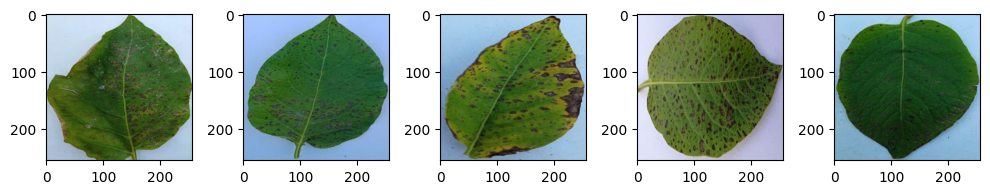


Displaying 5 sample images from class: Healthy


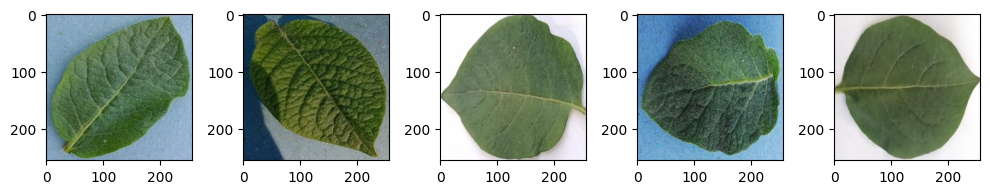


Displaying 5 sample images from class: Late_Blight


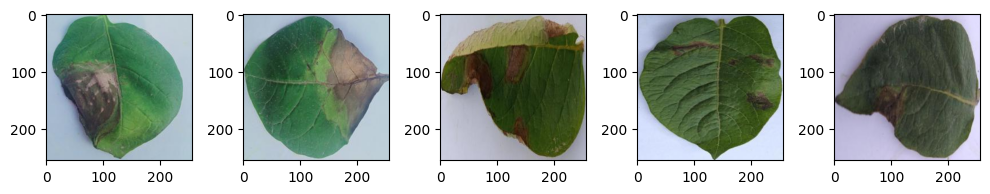

In [6]:
# Function to display sample images from each class
def display_sample_images(directory, num_samples=5):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            print(f"\nDisplaying {num_samples} sample images from class: {class_name}")
            class_images = os.listdir(class_path)
            sample_images = random.sample(class_images, num_samples)
            
            plt.figure(figsize=(10, 10))
            for i, image_name in enumerate(sample_images):
                img_path = os.path.join(class_path, image_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color format to RGB
                plt.subplot(1, num_samples, i+1)
                plt.imshow(img)
                plt.tight_layout()
            plt.show()

# Display sample images from training data
display_sample_images(train_dir)


<B>Preprocessing Zone</B>

In [9]:
# Image Dimensions
img_hight, img_width = 224 , 224    # it is a good size >> give us all the enough data >> suitable for pretrained models
BATCH_SIZE = 32 
SEED = 99   

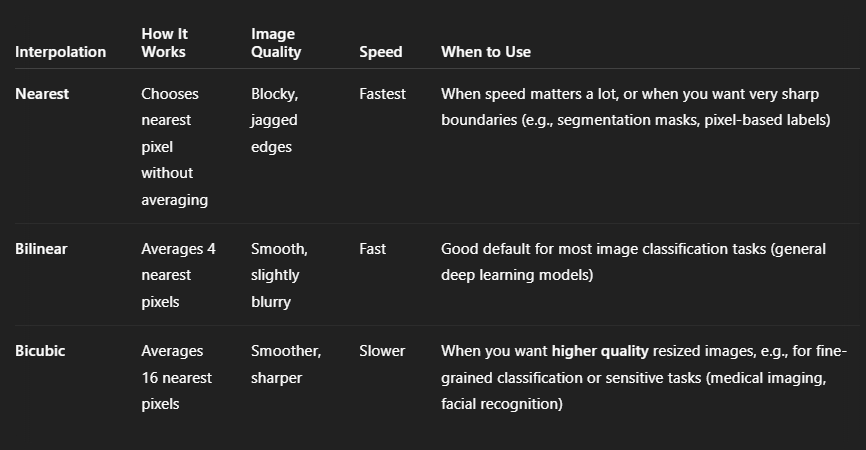

In [10]:
# Doing Data Augmentation with some preprocessing steps to avoid overfitting
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',           # the labels are inferred from the directory structure
    label_mode='categorical',    # Because we have more than two classes
    batch_size=BATCH_SIZE,
    image_size=(img_hight, img_width),
    shuffle=True,
    seed=SEED,
    interpolation='bicubic'
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(img_hight, img_width),
    shuffle=False,              # we don't want to shuffle the validation or the test data to evaluate the model fairly
    seed=SEED,
    interpolation='bicubic'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(img_hight, img_width),
    shuffle=False,
    seed=SEED,
    interpolation='bicubic'
)   

Found 3251 files belonging to 3 classes.
Found 416 files belonging to 3 classes.
Found 405 files belonging to 3 classes.


In [17]:
# by looking at the Training data >> There is no Balance So we have Options 
     # 1 - making Class wight >> to apply it when applying the model and computing the Loss 
     # 2 - Apply Data Augmentation 
# i prefer to make class weight to avoid overfitting  

# As we know we do this on Training data only 

# Classes
class_names = train_ds.class_names
class_indices = {name: idx for idx, name in enumerate(class_names)}

print(class_indices)

{'Early_Blight': 0, 'Healthy': 1, 'Late_Blight': 2}


In [20]:
# Number of samples per class (training set only)
train_counts = [1303, 816, 1132]  # You have this already


# Generate labels according to counts
labels = np.concatenate([
    np.full(train_counts[0], class_indices['Early_Blight']),
    np.full(train_counts[1], class_indices['Healthy']),
    np.full(train_counts[2], class_indices['Late_Blight']),
])

# Compute class weights
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dictionary
class_weight = dict(enumerate(class_weight))
print(class_weight)


{0: 0.8316705039652085, 1: 1.3280228758169934, 2: 0.9573027090694936}


In [21]:
from tensorflow.keras import layers 

# Data Augmentation Block 
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2), 
    layers.RandomTranslation(0.1, 0.1)  
])

In [22]:
rescale = layers.Rescaling(1./255)   # Normalization    

<b>Modeling USing CNN</b>

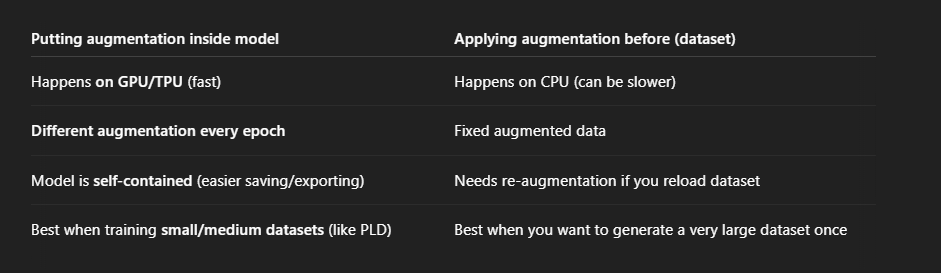

In [23]:
model = Sequential([
    layers.InputLayer(input_shape=(img_hight, img_width, 3)),
    data_augmentation,
    rescale,

    layers.Conv2D(32, (3, 3), activation='relu',padding='same'),   
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
102/102 [==============================] - 83s 662ms/step - loss: 1.1445 - accuracy: 0.3885 - val_loss: 1.0358 - val_accuracy: 0.4038
Epoch 2/30
102/102 [==============================] - 66s 646ms/step - loss: 1.0444 - accuracy: 0.4423 - val_loss: 0.9657 - val_accuracy: 0.5337
Epoch 3/30
102/102 [==============================] - 62s 609ms/step - loss: 1.0162 - accuracy: 0.4869 - val_loss: 0.9684 - val_accuracy: 0.5745
Epoch 4/30
102/102 [==============================] - 68s 669ms/step - loss: 1.0146 - accuracy: 0.4669 - val_loss: 0.8873 - val_accuracy: 0.5409
Epoch 5/30
102/102 [==============================] - 65s 636ms/step - loss: 0.8561 - accuracy: 0.6103 - val_loss: 0.7627 - val_accuracy: 0.7067
Epoch 6/30
102/102 [==============================] - 65s 634ms/step - loss: 0.8396 - accuracy: 0.6315 - val_loss: 0.7838 - val_accuracy: 0.6875
Epoch 7/30
102/102 [==============================] - 62s 609ms/step - loss: 0.7274 - accuracy: 0.7152 - val_loss: 0.5602 - val_ac

In [27]:
model.evaluate(test_ds)

13/13 [==============================] - 1s 85ms/step - loss: 0.1745 - accuracy: 0.9605


[0.17446531355381012, 0.960493803024292]

In [34]:
# see the classification Report 

from sklearn.metrics import classification_report
import numpy as np

all_true_labels = []
all_pred_labels = []

for test_images, test_labels in test_ds:
    # Convert one-hot encoded labels to integers
    true_labels = np.argmax(test_labels.numpy(), axis=1)  # shape -> (batch_size,)

    # Predict the model's output for the current batch
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)  # shape -> (batch_size,)

    # Save results
    all_true_labels.extend(true_labels)
    all_pred_labels.extend(predicted_classes)

# Generate the classification report
report = classification_report(all_true_labels, all_pred_labels, target_names=test_ds.class_names)
print(report)



1/1 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

Early_Blight       0.97      0.95      0.96       162
     Healthy       0.97      0.94      0.96       102
 Late_Blight       0.95      0.99      0.97       141

    accuracy                           0.96       405
   macro avg       0.96      0.96      0.96       405
weighted avg       0.96      0.96      0.96       405



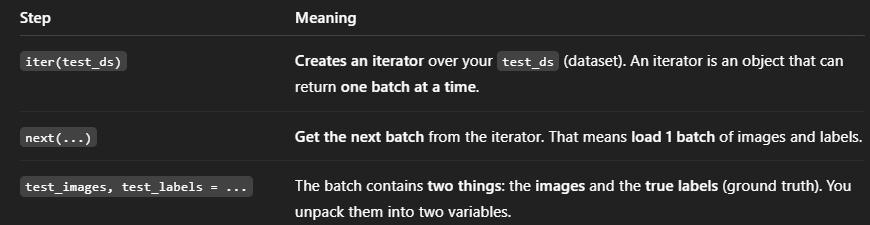

1/1 [==============================] - 0s 50ms/step


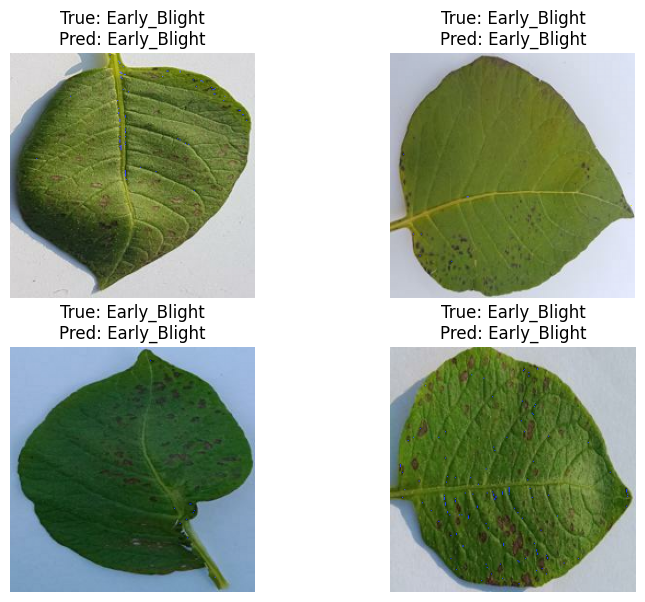

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_images = 4 

# Get a batch of images and labels from the test dataset
test_images, test_labels = next(iter(test_ds))

# Predict on the test images
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)  # Convert to class indices

# Convert one-hot encoded labels to integer class labels
true_labels = np.argmax(test_labels.numpy(), axis=1)

# Plot the images along with their true and predicted labels
plt.figure(figsize=(9, 7))

for i in range(num_images):
    plt.subplot(2, num_images//2, i+1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.title(f"True: {test_ds.class_names[true_labels[i]]}\nPred: {test_ds.class_names[predicted_classes[i]]}")
    plt.axis('off')

plt.show()


<B>Saving this model</B>

In [40]:
model.save('../models/CNN_potato_disease_model.h5')

<B>Load The model and test it from an image on the internet (simulating the production) </B>

1/1 [==============================] - 0s 170ms/step


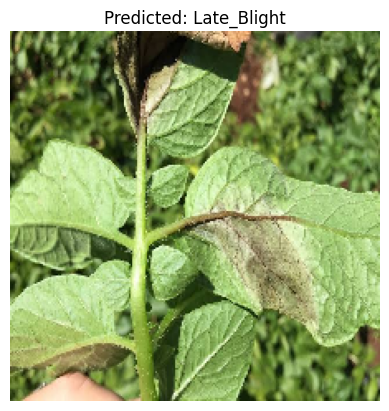

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('../models/CNN_potato_disease_model.h5')

image_path = 'C:\\Users\\aliay\\OneDrive\\Desktop\\iTi\\29 - Computer vision\\Day 1\\Lab 1\\Test_image_from_internet\\late_blight_potato.jpg'

# Now you can test the model with a single image
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension from (224, 224, 3) to (1, 224, 224, 3) to be compatible with the model

# Make prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)
predicted_label = test_ds.class_names[predicted_class[0]]

# Visualize the image and prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

In [44]:
# save an optimized version from the model to use it in deployment 
model = load_model('../models/CNN_potato_disease_model.h5')

# Convert the model to TensorFlow Lite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Apply optimizations, including quantization
tflite_model = converter.convert()

# Save the converted model
with open('../models/quantized_CNN_model.tflite', 'wb') as f:
    f.write(tflite_model)
 

INFO:tensorflow:Assets written to: C:\Users\aliay\AppData\Local\Temp\tmpt9iw7k1n\assets


INFO:tensorflow:Assets written to: C:\Users\aliay\AppData\Local\Temp\tmpt9iw7k1n\assets


In [46]:
# try this optimized model 

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=r"C:\Users\aliay\OneDrive\Desktop\iTi\29 - Computer vision\Day 1\Lab 1\models\quantized_CNN_model.tflite")

# Allocate tensors (this is required before running inference)
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input and output details for inspection
print("Input Details: ", input_details)
print("Output Details: ", output_details)

Input Details:  [{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details:  [{'name': 'StatefulPartitionedCall:0', 'index': 21, 'shape': array([1, 3]), 'shape_signature': array([-1,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [47]:
# Load and preprocess the image (replace 'input_image.jpg' with your image file)
img = cv2.imread('../Test_image_from_internet/late_blight_potato.jpg')  # Replace with your image path
img = cv2.resize(img, (224, 224))  # Resize to match model input size
img = np.expand_dims(img, axis=0)  # Add batch dimension (model expects input in batches)
img = img.astype(np.float32)  # Convert image to float32 as TensorFlow Lite expects this

# Normalize image if the model was trained with normalization (e.g., rescale to 0-1)
img = img / 255.0

In [48]:
# Set the input tensor with the preprocessed image
interpreter.set_tensor(input_details[0]['index'], img)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Display the raw output
print("Model Output: ", output_data)


Model Output:  [[0.38406414 0.09058087 0.52535504]]


In [49]:
# Assuming the output is a probability distribution (e.g., softmax output)
predicted_class = np.argmax(output_data, axis=1)

print(f"Predicted Class: {predicted_class}")


Predicted Class: [2]


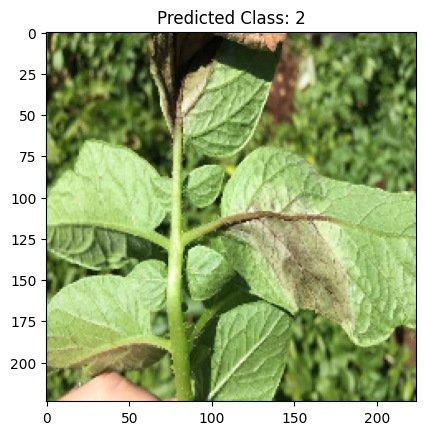

In [50]:
# Show the input image
plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Class: {predicted_class[0]}")
plt.show()


<h2><B>Applying Pre-Trained model and see the Results</B></h2>

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D ,Dropout , BatchNormalization

# Define the model architecture
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_hight, img_width, 3))

# 2. Freeze the base model (for now)
base_model.trainable = False

# 3. Build the custom head (good architecture)
x = base_model.output
x = GlobalAveragePooling2D()(x)               # Turn feature maps into a vector
x = BatchNormalization()(x)                   # Normalize to speed up learning
x = Dense(512, activation='relu')(x)          # Dense layer to learn high-level features
x = Dropout(0.5)(x)                           # Dropout to prevent overfitting
x = Dense(128, activation='relu')(x)          # Smaller dense layer
x = Dropout(0.3)(x)                           # Smaller dropout
outputs = Dense(3, activation='softmax')(x)   # Output layer (3 classes)

# 4. Define the final model
model = Model(inputs=base_model.input, outputs=outputs)

# 5. Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

16705208/16705208 [==============================] - 9s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)     

In [52]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
102/102 [==============================] - 15s 90ms/step - loss: 0.3229 - accuracy: 0.8939 - val_loss: 0.2005 - val_accuracy: 0.9471
Epoch 2/10
102/102 [==============================] - 7s 72ms/step - loss: 0.2119 - accuracy: 0.9329 - val_loss: 0.1214 - val_accuracy: 0.9663
Epoch 3/10
102/102 [==============================] - 8s 78ms/step - loss: 0.1399 - accuracy: 0.9517 - val_loss: 0.0800 - val_accuracy: 0.9832
Epoch 4/10
102/102 [==============================] - 8s 75ms/step - loss: 0.1217 - accuracy: 0.9600 - val_loss: 0.0691 - val_accuracy: 0.9784
Epoch 5/10
102/102 [==============================] - 7s 72ms/step - loss: 0.1096 - accuracy: 0.9662 - val_loss: 0.0716 - val_accuracy: 0.9832
Epoch 6/10
102/102 [==============================] - 7s 72ms/step - loss: 0.0865 - accuracy: 0.9739 - val_loss: 0.0692 - val_accuracy: 0.9712
Epoch 7/10
102/102 [==============================] - 8s 78ms/step - loss: 0.0685 - accuracy: 0.9760 - val_loss: 0.0486 - val_accuracy: 0.983

In [53]:
model.evaluate(test_ds) 

13/13 [==============================] - 1s 60ms/step - loss: 0.0872 - accuracy: 0.9679


[0.08722575753927231, 0.9679012298583984]

In [54]:
# see the classification Report 

from sklearn.metrics import classification_report
import numpy as np

all_true_labels = []
all_pred_labels = []

for test_images, test_labels in test_ds:
    # Convert one-hot encoded labels to integers
    true_labels = np.argmax(test_labels.numpy(), axis=1)  # shape -> (batch_size,)

    # Predict the model's output for the current batch
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)  # shape -> (batch_size,)

    # Save results
    all_true_labels.extend(true_labels)
    all_pred_labels.extend(predicted_classes)

# Generate the classification report
report = classification_report(all_true_labels, all_pred_labels, target_names=test_ds.class_names)
print(report)



1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

Early_Blight       0.98      0.98      0.98       162
     Healthy       0.99      0.94      0.96       102
 Late_Blight       0.94      0.98      0.96       141

    accuracy                           0.97       405
   macro avg       0.97      0.97      0.97       405
weighted avg       0.97      0.97      0.97       405



1/1 [==============================] - 0s 45ms/step


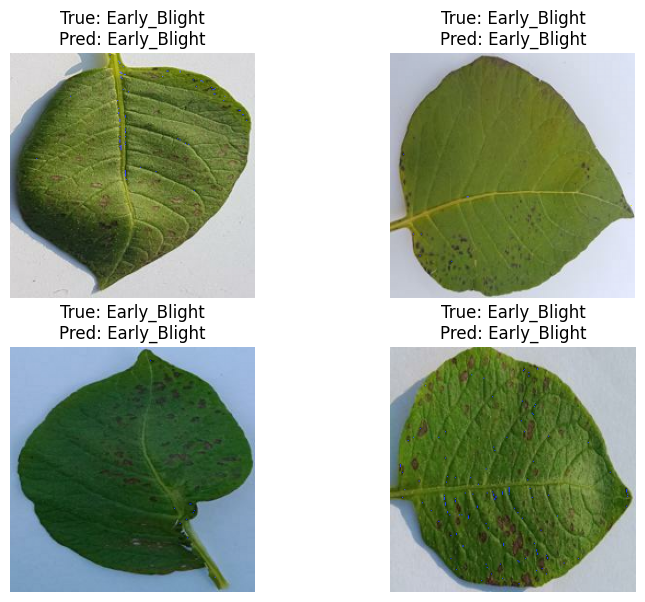

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_images = 4 

# Get a batch of images and labels from the test dataset
test_images, test_labels = next(iter(test_ds))

# Predict on the test images
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)  # Convert to class indices

# Convert one-hot encoded labels to integer class labels
true_labels = np.argmax(test_labels.numpy(), axis=1)

# Plot the images along with their true and predicted labels
plt.figure(figsize=(9, 7))

for i in range(num_images):
    plt.subplot(2, num_images//2, i+1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.title(f"True: {test_ds.class_names[true_labels[i]]}\nPred: {test_ds.class_names[predicted_classes[i]]}")
    plt.axis('off')

plt.show()


In [ ]:
# Good Results too but i will go for the CNN model because it is more simple and there is no a big difference between both 